# NICCOLO PISILLI

## Set data fot scatterplot

In [45]:
from matplotlib import font_manager
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import re
from mplsoccer import VerticalPitch
import matplotlib.patches as mpatches
import matplotlib.image as mpimg

## Extract data from WhoScored

In [1]:
list_html = [
    '/Users/alfonsomarino/Desktop/Roma 2-1 Venezia - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Elfsborg 1-0 Roma - Europa League 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Genoa 1-1 Roma - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Juventus 0-0 Roma - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Roma 1-1 Athletic Club - Europa League 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Roma 3-0 Udinese - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Monza 1-1 Roma - Serie A 2024:2025 - Live.html'
]

In [2]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [3]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict

In [4]:
def create_events_dict(path, player_id = 476440):
    json_data_txt = extract_json_from_html(path)
    data = json.loads(json_data_txt)
    events_dict = extract_data_from_dict(data)
    # Creating the initial DataFrame
    event_data = [extract_event_data(event) for event in events_dict]
    df = pd.DataFrame(event_data)

    # Find all possible qualifiers
    all_qualifiers = set()
    for event in events_dict:
        for qualifier in event.get('qualifiers', []):
            all_qualifiers.add(qualifier['type']['displayName'])

    # Add missing columns with null values or “No” if it is a qualifier.
    for qualifier in all_qualifiers:
        if qualifier not in df.columns:
            if df[qualifier].dtype == object: 
                df[qualifier] = "No"
            else:
                df[qualifier] = None

    df = df[df["Player ID"]== player_id]
    pisilli_3rd = df[df["Start X"] > 60][["Event Type", "Start X", "Start Y"]]

    return data, events_dict

In [5]:
def extract_event_data(event):
    event_data = {
        "Player ID" : event.get("playerId", None),
        'Event Type': event['type']['displayName'],
        'Event Value': event['type']['value'],
        'Outcome': event['outcomeType']['displayName'],
        "Minuto" : event["minute"],
        'Start X': event['x'],
        'Start Y': event['y'],
        'End X': event.get('endX', None),  # It may not be in all events
        'End Y': event.get('endY', None)   # Potrebbe non esserci in tutti gli eventi
    }

    # Managing qualifiers, creating dynamic columns for each displayName
    qualifier_columns = {}
    for qualifier in event.get('qualifiers', []):
        q_display_name = qualifier['type']['displayName']
        q_value = qualifier.get('value', None)
        
        # If there is no value, we create a column with “Yes” or “No”
        if q_value is None:
            qualifier_columns[q_display_name] = "Yes"
        else:
            # If the name already exists, add a numeric suffix
            if q_display_name in qualifier_columns:
                i = 1
                while f"{q_display_name}_{i}" in qualifier_columns:
                    i += 1
                q_display_name = f"{q_display_name}_{i}"
            
            qualifier_columns[q_display_name] = q_value
    
    # Add qualifiers to the event
    event_data.update(qualifier_columns)
    
    return event_data

In [9]:
# Add qualifiers to the event
all_dataframes = []

# Itera through HTML file paths
for path in list_html:
    pisilli_data = create_events_dict(path)
    all_dataframes.append(pisilli_data)

# Concatenate all DataFrames into one
final_dataframe = pd.concat(all_dataframes, ignore_index=True)

In [10]:
final_dataframe["Event Type"].unique()

array(['Pass', 'MissedShots', 'SavedShot', 'Goal', 'BallRecovery',
       'CornerAwarded', 'Foul', 'TakeOn', 'Dispossessed', 'BallTouch',
       'BlockedPass', 'Aerial'], dtype=object)

In [11]:
color_map = {
    'Pass': 'darkred',   
    'Goal': 'orange',    
    'MissedShots': 'orange',  
    'SavedShot': 'orange',     
    'Other': '#003153'      
}

In [12]:
final_dataframe['Color'] = final_dataframe['Event Type'].apply(lambda x: color_map.get(x, color_map['Other']))
final_dataframe

,Event Type,Start X,Start Y,Color
0,Pass,60.6,82.7,darkred
1,MissedShots,92.3,52.2,orange
2,Pass,60.9,79.2,darkred
3,Pass,64.0,82.8,darkred
4,Pass,68.3,26.8,darkred
...,...,...,...,...
147,Dispossessed,73.2,59.6,#003153
148,Pass,76.4,18.5,darkred
149,Pass,70.2,10.0,darkred
150,Pass,65.4,14.2,darkred


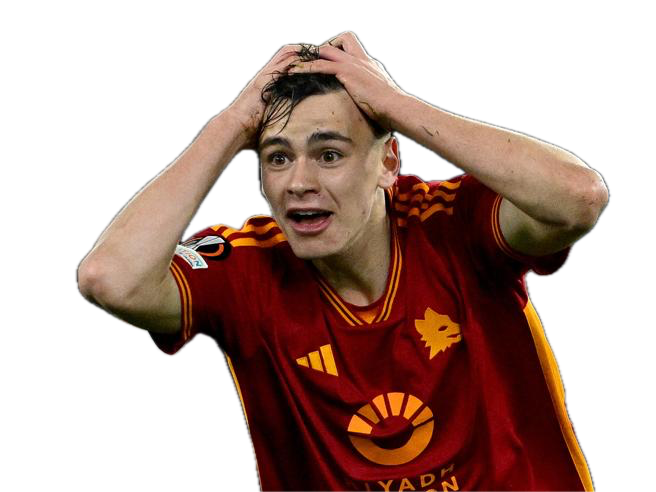

In [14]:
from PIL import Image
image_path = '/Users/alfonsomarino/Desktop/pisilli senza sfondo.png'
img = Image.open(image_path)
img

## The Viz

In [ ]:
background_color = "blanchedalmond"

font_path_regular = '/Users/alfonsomarino/Desktop/Teko/static/Teko-Regular.ttf'
# Create a font properties object with the font file
font_normal = font_manager.FontProperties(fname=font_path_regular)

font_path_med = "/Users/alfonsomarino/Desktop/Teko/static/Teko-Medium.ttf"
font_med = font_manager.FontProperties(fname = font_path_med)

font_path_semi = "/Users/alfonsomarino/Desktop/Teko/static/Teko-SemiBold.ttf"
font_semi = font_manager.FontProperties(fname = font_path_semi)

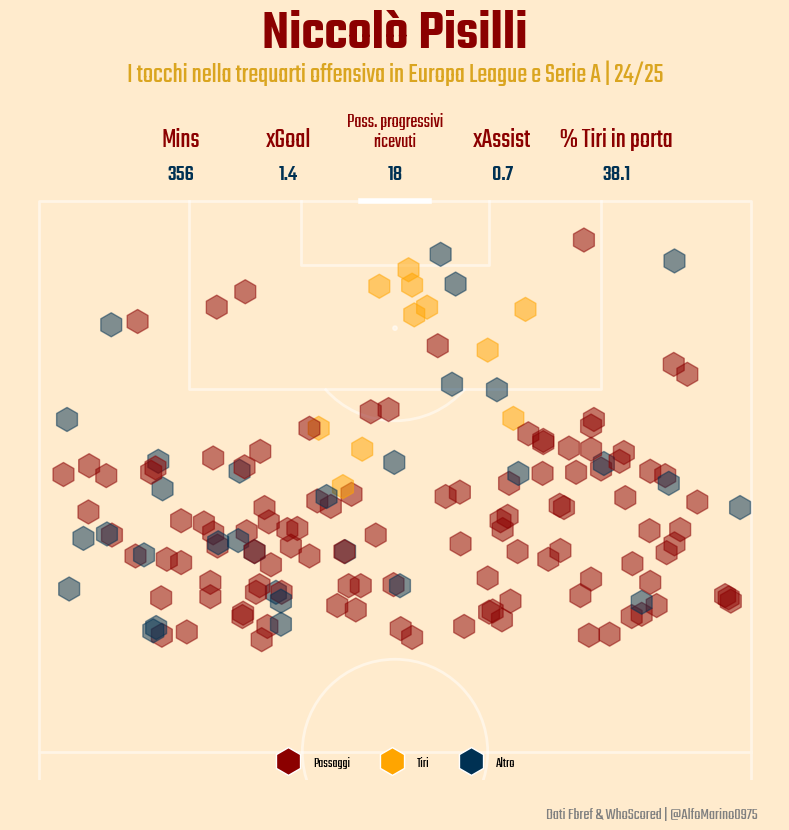

In [60]:
pitch = VerticalPitch(pitch_type='opta', pitch_color=background_color, line_color='white',line_alpha=.5, half = True)
fig, ax = pitch.draw(figsize=(8, 12), constrained_layout=False, tight_layout=True)
fig.set_facecolor(background_color)

pitch.scatter(final_dataframe["Start X"], final_dataframe["Start Y"], s= 300, ax = ax, c=final_dataframe['Color'], alpha=.5, marker = "h")

ax.text(
    x=50, 
    y=114, 
    s='Niccolò Pisilli', 
    fontsize=40, 
    fontproperties=font_semi,  
    color='darkred', 
    ha='center'
)

ax.text(
    x=50, 
    y=110.9, 
    s='I tocchi nella trequarti offensiva in Europa League e Serie A | 24/25', 
    fontsize=20, 
    fontproperties=font_normal,  
    color='goldenrod', 
    ha='center'
)

legend_elements = [plt.Line2D([0], [0], marker='h', color='w', markerfacecolor='darkred', markersize=20, label='Passaggi', linewidth=0),
                   plt.Line2D([0], [0], marker='h', color='w', markerfacecolor='orange', markersize=20, label='Tiri', linewidth=0),
                   plt.Line2D([0], [0], marker='h', color='w', markerfacecolor='#003153', markersize=20, label='Altro', linewidth=0)]
ax.legend(handles=legend_elements, loc='lower center', frameon=False, ncol= 3, prop=font_normal)

ax.text(
    x=14, 
    y=44, 
    s= "Dati Fbref & WhoScored | @AlfoMarino0975", 
    fontsize=12, 
    fontproperties=font_normal,  
    color='grey', 
    ha='center'
)

ax.text(
    x=80, 
    y=105, 
    s='Mins', 
    fontsize=20, 
    fontproperties=font_normal,  
    color='darkred', 
    ha='center'
)

ax.text(
    x=80, 
    y=102, 
    s='356', 
    fontsize=16, 
    fontproperties=font_med,  
    color='#003153', 
    ha='center'
)

ax.text(
    x=65, 
    y=105, 
    s='xGoal', 
    fontsize=20, 
    fontproperties=font_normal,  
    color='darkred', 
    ha='center'
)

ax.text(
    x=65, 
    y=102, 
    s='1.4', 
    fontsize=16, 
    fontproperties=font_med,  
    color='#003153', 
    ha='center'
)

ax.text(
    x=50, 
    y=105, 
    s='Pass. progressivi\nricevuti', 
    fontsize=14, 
    fontproperties=font_normal,  
    color='darkred', 
    ha='center'
)

ax.text(
    x=50, 
    y=102, 
    s='18', 
    fontsize=16, 
    fontproperties=font_med,  
    color='#003153', 
    ha='center'
)

ax.text(
    x=35, 
    y=105, 
    s='xAssist', 
    fontsize=20, 
    fontproperties=font_normal,  
    color='darkred', 
    ha='center'
)

ax.text(
    x=35, 
    y=102, 
    s='0.7', 
    fontsize=16, 
    fontproperties=font_med,  
    color='#003153', 
    ha='center'
)

ax.text(
    x=19, 
    y=105, 
    s='% Tiri in porta', 
    fontsize=20, 
    fontproperties=font_normal,  
    color='darkred', 
    ha='center'
)

ax.text(
    x=19, 
    y=102, 
    s='38.1', 
    fontsize=16, 
    fontproperties=font_med,  
    color='#003153', 
    ha='center'
)


ax.set_axis_off()


output_path = "/Users/alfonsomarino/Desktop/pisilli3rd.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())